In [141]:
import pandas
import nipy
from nipy.modalities.fmri import hrf

In [142]:
df = pandas.read_csv('data/sim-data_drift-SP-variability-estim-onep.csv', index_col=0)

In [143]:
import numpy as np

In [144]:
df['onset'] = np.arange(10, len(df)*10 + 1, 10)

In [157]:
def get_bold_response(df, method='time_on_task',
                      cue_delay=None,
                      sample_rate=1000):
    
    neural_signal = np.zeros((df.onset.max() + 20) * sample_rate)
    
    hrf = nipy.modalities.fmri.hrf.spm_hrf_compat(np.arange(0, 20, 1./sample_rate))
    
    for ix, row in df.iterrows():
        
        if method == 'time_on_task':
            start_idx = int(row.onset * sample_rate)
            end_idx = int((row.onset + row.rt)*sample_rate)
            value = 1
            
        elif method == 'time_on_task_drift':
            start_idx = int(row.onset * sample_rate)
            end_idx = int((row.onset + row.rt)*sample_rate)
            value = row.drift_t   
            
        elif method == 'error_monitoring':            
            feedback_delay = np.random.choice([.200, .700, 1.200, 1.700])            
            start_idx = int((row.onset + row.rt+feedback_delay)*sample_rate)
            end_idx = int(start_idx + .35 *sample_rate)            
            value =  1.5  - row.accuracy
        
        if cue_delay is None:        
            neural_signal[start_idx:end_idx] = value
        else:            
            offset = np.random.choice(cue_delay) * sample_rate            
            neural_signal[start_idx+offset:end_idx+offset] = value
            
        
    
    bold_signal = np.convolve(hrf, neural_signal)
    
    return neural_signal, bold_signal
    
    

# Time on task

In [ ]:


import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
sample_rate = 100

In [42]:
neural_signal, bold_signal = get_bold_response(df, sample_rate=sample_rate)

In [43]:
from nipy.modalities.fmri.experimental_paradigm import EventRelatedParadigm

In [44]:
paradigm = EventRelatedParadigm(['trial %d' % (ix+1) for ix in df.index], df.onset.tolist())

In [45]:
from scipy import signal

In [46]:
tr = 2.0

In [48]:
bold_signal = signal.resample_poly(bold_signal, 1, sample_rate * tr)

In [49]:
import nipy.modalities.fmri.design_matrix as dm


In [87]:
n_scans = len(bold_signal)

# paradigm
frametimes = np.linspace(0, (n_scans - 1) * tr, n_scans)

# confounds
hrf_model = 'canonical'
drift_model = "polynomial"

X, names = dm.dmtx_light(frametimes, paradigm, drift_model=drift_model, drift_order=0, hrf_model=hrf_model)

In [88]:
import statsmodels.api as sm

In [89]:
model = sm.OLS(bold_signal, pandas.DataFrame(X, columns=names))

In [90]:
results = model.fit()

In [110]:
single_trial_betas = pandas.DataFrame(results.params).reset_index()
single_trial_betas = single_trial_betas.drop(2000)
single_trial_betas = single_trial_betas.rename(columns={0:'beta'})
single_trial_betas['trial'] = single_trial_betas['index'].apply(lambda x: int(x.split()[-1]))

In [115]:
df = df.merge(single_trial_betas, on='trial')

In [116]:
df.to_csv('data/sim-data_drift-SP-variability-estim-onep_time_on_task_beta.csv')

In [117]:
import seaborn as sns

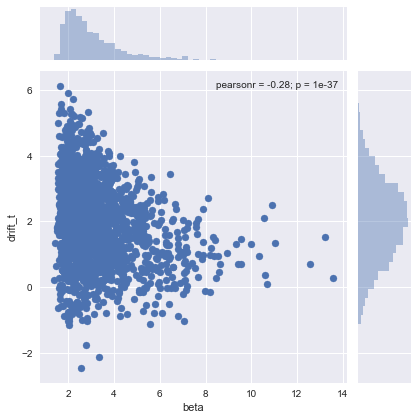

In [120]:
sns.jointplot('beta', 'drift_t', df)

# time_on_task * drift

In [127]:
sample_rate = 100
neural_signal, bold_signal = get_bold_response(df, method='time_on_task_drift', sample_rate=sample_rate)
paradigm = EventRelatedParadigm(['trial %d' % (ix+1) for ix in df.index], df.onset.tolist())
tr = 2.0
bold_signal = signal.resample_poly(bold_signal, 1, sample_rate * tr)

(0, 200)

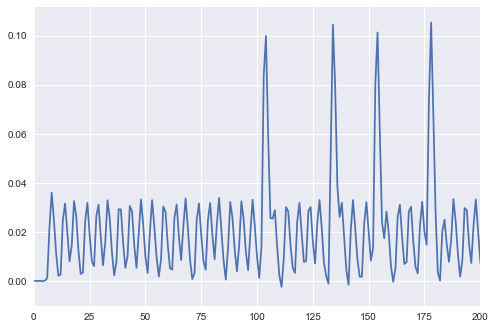

In [149]:
plt.plot(bold_signal)
plt.xlim(0, 200)

In [129]:
n_scans = len(bold_signal)

# paradigm
frametimes = np.linspace(0, (n_scans - 1) * tr, n_scans)

# confounds
hrf_model = 'canonical'
drift_model = "polynomial"

X, names = dm.dmtx_light(frametimes, paradigm, drift_model=drift_model, drift_order=0, hrf_model=hrf_model)

In [130]:
model = sm.OLS(bold_signal, pandas.DataFrame(X, columns=names))
results = model.fit()

In [131]:
single_trial_betas = pandas.DataFrame(results.params).reset_index()
single_trial_betas = single_trial_betas.drop(2000)
single_trial_betas = single_trial_betas.rename(columns={0:'beta'})
single_trial_betas['trial'] = single_trial_betas['index'].apply(lambda x: int(x.split()[-1]))

In [132]:
df = pandas.read_csv('data/sim-data_drift-SP-variability-estim-onep.csv', index_col=0)
df = df.merge(single_trial_betas, on='trial')

In [133]:
df.to_csv('data/sim-data_drift-SP-variability-estim-onep_time_on_task_drift_beta.csv')

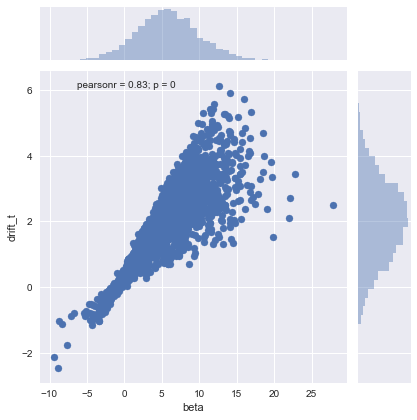

In [134]:
sns.jointplot('beta', 'drift_t', df)

# Error signal

In [148]:
sample_rate = 100
neural_signal, bold_signal = get_bold_response(df, method='error_monitoring', sample_rate=sample_rate)
paradigm = EventRelatedParadigm(['trial %d' % (ix+1) for ix in df.index], df.onset.tolist())
tr = 2.0
bold_signal = signal.resample_poly(bold_signal, 1, sample_rate * tr)

(0, 200)

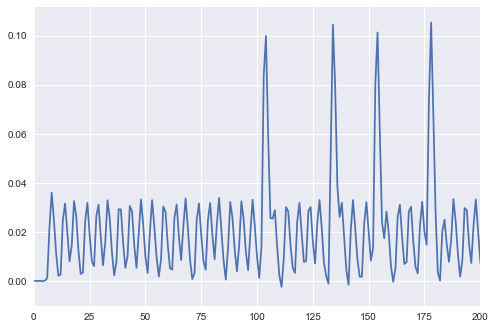

In [150]:
plt.plot(bold_signal)
plt.xlim(0, 200)

In [151]:
n_scans = len(bold_signal)

# paradigm
frametimes = np.linspace(0, (n_scans - 1) * tr, n_scans)

# confounds
hrf_model = 'canonical'
drift_model = "polynomial"

X, names = dm.dmtx_light(frametimes, paradigm, drift_model=drift_model, drift_order=0, hrf_model=hrf_model)

In [152]:
model = sm.OLS(bold_signal, pandas.DataFrame(X, columns=names))
results = model.fit()

In [153]:
single_trial_betas = pandas.DataFrame(results.params).reset_index()
single_trial_betas = single_trial_betas.drop(2000)
single_trial_betas = single_trial_betas.rename(columns={0:'beta'})
single_trial_betas['trial'] = single_trial_betas['index'].apply(lambda x: int(x.split()[-1]))

In [154]:
df = pandas.read_csv('data/sim-data_drift-SP-variability-estim-onep.csv', index_col=0)
df = df.merge(single_trial_betas, on='trial')

In [155]:
df.to_csv('data/sim-data_drift-SP-variability-estim-onep_error_monitoring.csv')

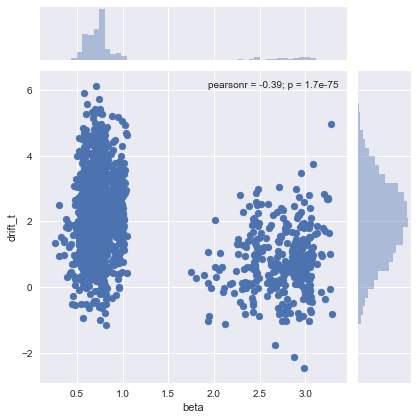

In [156]:
sns.jointplot('beta', 'drift_t', df)

# Error signal with cue

In [175]:
df = pandas.read_csv('data/sim-data_drift-SP-variability-estim-onep.csv', index_col=0)

In [176]:
df['onset'] = np.arange(10, len(df)*10 + 1, 10)

In [177]:
from nipy.modalities.fmri.experimental_paradigm import BlockParadigm

In [179]:
sample_rate = 100
neural_signal, bold_signal = get_bold_response(df, method='error_monitoring', cue_delay=[2, 3, 4, 5], sample_rate=sample_rate)
paradigm = BlockParadigm(['trial %d' % (ix+1) for ix in df.index], df.onset.tolist(), duration=[2]*df.shape[0])
tr = 2.0
bold_signal = signal.resample_poly(bold_signal, 1, sample_rate * tr)

In [180]:
n_scans = len(bold_signal)

# paradigm
frametimes = np.linspace(0, (n_scans - 1) * tr, n_scans)

# confounds
hrf_model = 'canonical'
drift_model = "polynomial"

X, names = dm.dmtx_light(frametimes, paradigm, drift_model=drift_model, drift_order=0, hrf_model=hrf_model)

In [181]:
model = sm.OLS(bold_signal, pandas.DataFrame(X, columns=names))
results = model.fit()

In [182]:
single_trial_betas = pandas.DataFrame(results.params).reset_index()
single_trial_betas = single_trial_betas.drop(2000)
single_trial_betas = single_trial_betas.rename(columns={0:'beta'})
single_trial_betas['trial'] = single_trial_betas['index'].apply(lambda x: int(x.split()[-1]))

In [183]:
df = pandas.read_csv('data/sim-data_drift-SP-variability-estim-onep.csv', index_col=0)
df = df.merge(single_trial_betas, on='trial')

In [184]:
df.to_csv('data/sim-data_drift-SP-variability-estim-onep_error_monitoring_cue_delay.csv')

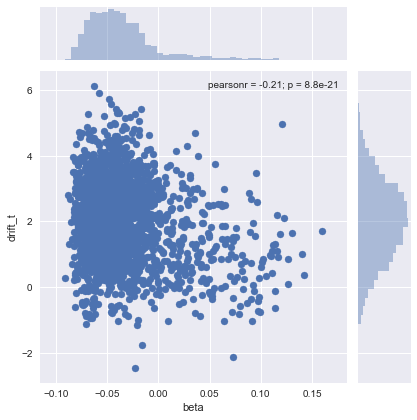

In [185]:
sns.jointplot('beta', 'drift_t', df)

## Some plots

In [186]:
tot = pandas.read_csv('data/sim-data_drift-SP-variability-estim-onep_time_on_task_beta.csv')

In [187]:
tot.head()

Unnamed: 0  SP_m  SP_sd      SP_t  accuracy  drift_m  drift_sd   drift_t  \
0           0  -0.1    0.1  0.474455         1        2       1.2  1.971660   
1           1  -0.1    0.1  0.421582         1        2       1.2  2.412196   
2           2  -0.1    0.1  0.440954         1        2       1.2  1.552231   
3           3  -0.1    0.1  0.434787         1        2       1.2  2.604858   
4           4  -0.1    0.1  0.365565         1        2       1.2  1.242914   

   ndt  participant     rt  threshold  trial  onset    index      beta  
0  0.3            1  0.525        1.2      1     10  trial 1  2.591663  
1  0.3            1  0.521        1.2      2     20  trial 2  2.711804  
2  0.3            1  0.641        1.2      3     30  trial 3  3.528447  
3  0.3            1  0.553        1.2      4     40  trial 4  3.016930  
4  0.3            1  0.442        1.2      5     50  trial 5  2.268155

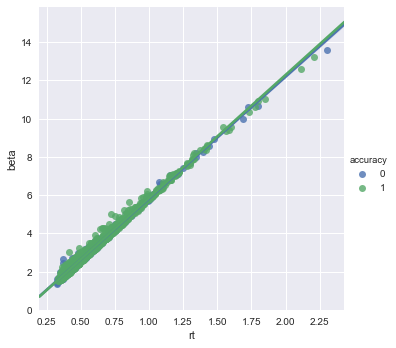

In [189]:
sns.lmplot('rt', 'beta', tot, 'accuracy')